### Convert to Binary Image:
Use image processing software (e.g., ImageJ, Python, MATLAB) to threshold the image and create a binary mask where pores are white (1) and the polymer film is black (0).

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import measure

image_path = 'sample2A.jpg'
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Preprocess the image (thresholding to highlight pores)
_, binary_image = cv2.threshold(image, 128, 255, cv2.THRESH_BINARY_INV)

# Find contours of the pores
contours = measure.find_contours(binary_image, 0.8)

# Extract centroids of the pores
centroids = []
for contour in contours:
    M = cv2.moments(contour)
    if M["m00"] != 0:
        cx = int(M["m10"] / M["m00"])  # X-coordinate of centroid
        cy = int(M["m01"] / M["m00"])  # Y-coordinate of centroid
        centroids.append((cx, cy))

centroids = np.array(centroids)

In [3]:
print(centroids)

[[0 2]
 [0 1]
 [0 1]
 ...
 [0 1]
 [0 0]
 [0 0]]


 ## Extract Droplet Centroids

[[ 644 2308]
 [1817 2299]
 [ 950 2270]
 [ 112 2257]
 [2878 2161]
 [2383 2190]
 [2673 2193]
 [  79 2157]
 [2923 2195]
 [   5 2165]
 [2052 2183]
 [1258 2182]
 [  80 2131]
 [  44 2123]
 [ 466 2188]
 [  25 2087]
 [1605 2179]
 [ 762 2144]
 [1861 2111]
 [1059 2074]
 [ 984 1938]
 [3068 1962]
 [ 349 1916]
 [2559 2025]
 [1815 1905]
 [1430 1879]
 [2862 2009]
 [1345 1976]
 [ 174 2010]
 [ 227 1861]
 [2320 1859]
 [2245 2000]
 [1399 1858]
 [ 205 1846]
 [1439 1832]
 [ 562 1940]
 [1361 1825]
 [1286 1813]
 [1416 1783]
 [1379 1777]
 [1371 1773]
 [1463 1770]
 [ 855 1864]
 [1244 1754]
 [1632 1865]
 [1317 1738]
 [1553 1724]
 [1118 1817]
 [1318 1707]
 [2452 1799]
 [1952 1830]
 [1346 1707]
 [1358 1665]
 [1652 1639]
 [2714 1744]
 [ 367 1735]
 [2934 1718]
 [ 119 1682]
 [1665 1571]
 [2208 1662]
 [ 673 1657]
 [  41 1510]
 [ 950 1613]
 [1665 1512]
 [1790 1597]
 [1541 1594]
 [1236 1591]
 [1476 1450]
 [ 225 1506]
 [2512 1535]
 [1537 1420]
 [1518 1403]
 [ 485 1454]
 [2311 1408]
 [1062 1398]
 [2393 1311]
 [3031 1420]

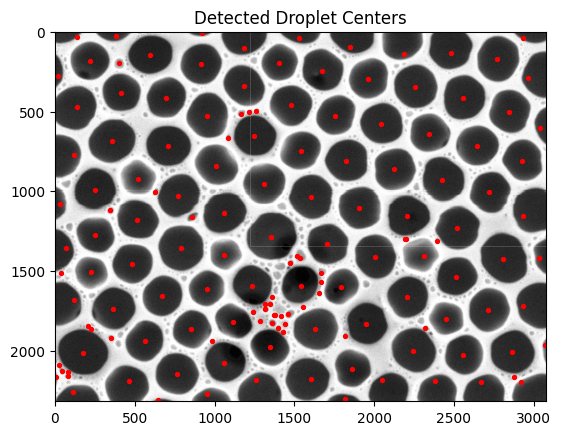

In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image in grayscale
image_path = "sample5B.png"  # Update with your image path if needed
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Apply median blur to reduce noise
blurred = cv2.medianBlur(image, 5)

# Use Otsu's thresholding to create a binary mask
_, binary = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# Perform morphological closing to fill small gaps
kernel = np.ones((5, 5), np.uint8)
closed = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel, iterations=2)

# Detect edges using Canny edge detector
edges = cv2.Canny(closed, 50, 150)

# Find contours
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Convert to color image for visualization
output_final = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

# Draw detected pore centers
centroids = []
for cnt in contours:
    M = cv2.moments(cnt)
    if M["m00"] != 0:
        cx = int(M["m10"] / M["m00"])
        cy = int(M["m01"] / M["m00"])
        centroids.append((cx, cy))

# Convert to NumPy array
centroids = np.array(centroids)

print(centroids)
# Step 5: Plot the results
plt.imshow(image, cmap='gray')
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=8)
plt.title('Detected Droplet Centers')
plt.show()

[[1595 1436]
 [2066 1414]
 [ 985 1398]
 [2503 1397]
 [ 754 1351]
 [ 481 1353]
 [1798 1350]
 [2314 1323]
 [ 160 1304]
 [1525 1280]
 [ 122 1106]
 [1221 1246]
 [ 216 1051]
 [2488 1165]
 [2023 1180]
 [2454 1033]
 [ 933 1161]
 [ 226 1012]
 [ 656 1111]
 [  11 1091]
 [ 381 1085]
 [ 146 1017]
 [1726 1048]
 [2288 1004]
 [1775  860]
 [1780  859]
 [1428  984]
 [1138  928]
 [2210  784]
 [ 848  881]
 [2491  864]
 [ 564  839]
 [ 300  806]
 [1985  822]
 [1603  761]
 [  63  779]
 [1333  701]
 [  99  540]
 [2309  677]
 [1051  647]
 [2510  565]
 [ 850  499]
 [ 196  563]
 [1779  571]
 [ 742  595]
 [ 453  560]
 [1519  482]
 [2055  464]
 [1237  422]
 [  32  414]
 [ 942  365]
 [2365  359]
 [1602  221]
 [ 271  299]
 [ 613  302]
 [1676  124]
 [1681  120]
 [1777  252]
 [1430  203]
 [1144  139]
 [2415   83]
 [2234    0]
 [2111  137]
 [1890   22]
 [1614   46]
 [1351   16]
 [ 843   97]
 [ 559   51]
 [ 284   49]
 [  64  112]]


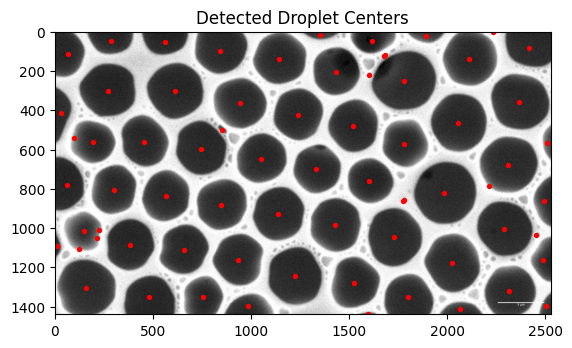

In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
image_path = "sample9A.png"
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Apply Gaussian blur to smooth the image
blurred = cv2.GaussianBlur(image, (5, 5), 0)

# Apply thresholding to create a binary image
_, binary = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# Find contours
contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Create a copy of the image to draw on
output = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

# Calculate and draw centroids
centroids = []
for contour in contours:
    M = cv2.moments(contour)
    if M["m00"] != 0:
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
        centroids.append((cX, cY))
        cv2.circle(output, (cX, cY), 3, (0, 0, 255), -1)

# Show the output image with centroids
centroids =  np.array(centroids)

print(centroids)
# Convert to NumPy array
# Step 5: Plot the results
plt.imshow(image, cmap='gray')
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=8)
plt.title('Detected Droplet Centers')
plt.show()


## Perform Voronoi Tessellation

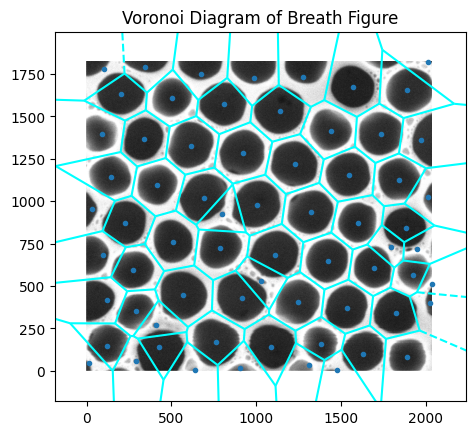

In [6]:
from scipy.spatial import Voronoi, voronoi_plot_2d

# Compute Voronoi Tessellation
vor = Voronoi(centroids)

# Plot Voronoi Diagram
fig, ax = plt.subplots()
ax.imshow(image, cmap='gray')
voronoi_plot_2d(vor, ax=ax, show_vertices=False, line_colors='cyan', line_width=1.5)
plt.title('Voronoi Diagram of Breath Figure')
plt.show()


## Analyze Voronoi Cell Shapes

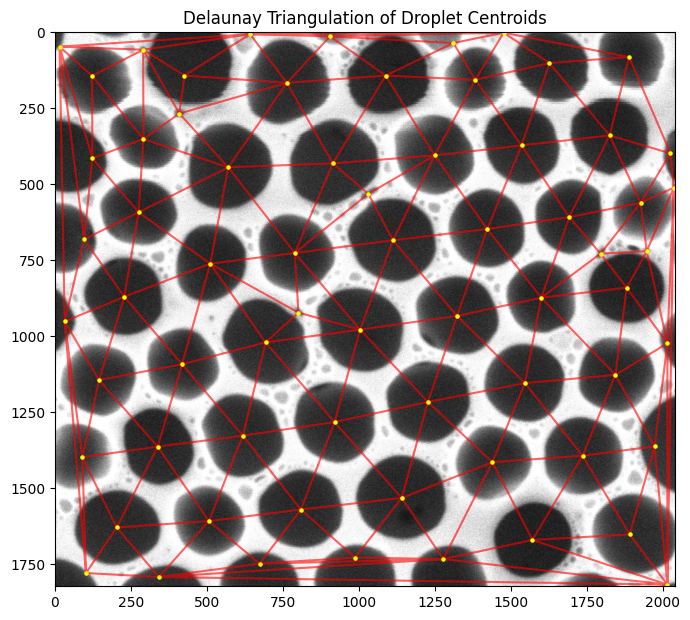

In [7]:
import cv2
import numpy as np
from scipy.spatial import Delaunay
import matplotlib.pyplot as plt

# Load SEM Image
# Preprocess Image (assuming previous steps are done and centroids are detected)
# This part assumes that centroids are already identified, e.g., using contours or other method

# Example centroid array (replace with actual centroids)
# centroids = np.array([[100, 150], [200, 250], [300, 350], ...])

# Compute Delaunay Triangulation (corrected to use centroids as (x, y))
tri = Delaunay(centroids)

# Plotting the Image with Delaunay Triangulation
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(image, cmap='gray')
ax.triplot(centroids[:, 0], centroids[:, 1], tri.simplices, color='red', alpha=0.6)
plt.scatter(centroids[:, 0], centroids[:, 1], c='yellow', s=5)
plt.title('Delaunay Triangulation of Droplet Centroids')
plt.show()


## Quantitative Metrics

Hexagonality Ratio: 0.49


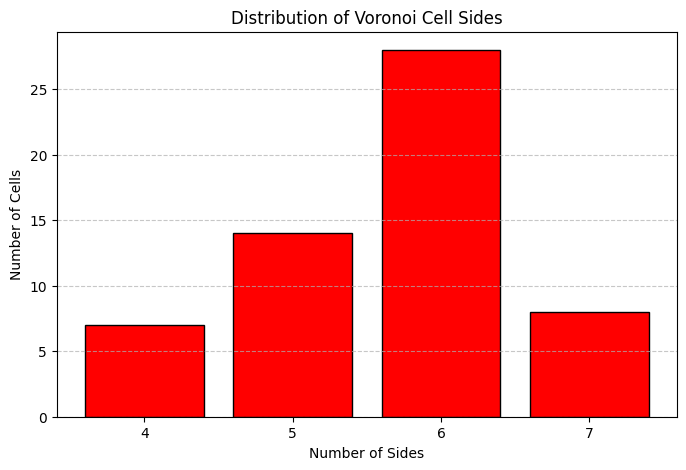

In [8]:
import networkx as nx
import matplotlib.pyplot as plt

# Construct Graph from Voronoi
graph = nx.Graph()
for i, region in enumerate(vor.regions):
    if -1 in region or len(region) == 0:
        continue
    graph.add_node(i, sides=len(region))

# Extract Number of Hexagonal Cells
hexagonal_cells = [n for n, attr in graph.nodes(data=True) if attr['sides'] == 6]
hexagonality_ratio = len(hexagonal_cells) / len(graph.nodes)

print(f'Hexagonality Ratio: {hexagonality_ratio:.2f}')

# Count the number of cells for each number of sides
side_counts = {}
for n, attr in graph.nodes(data=True):
    sides = attr['sides']
    if sides in side_counts:
        side_counts[sides] += 1
    else:
        side_counts[sides] = 1

# Sort the sides for better visualization
sorted_sides = sorted(side_counts.keys())

# Create bar plot
plt.figure(figsize=(8, 5))
plt.bar(sorted_sides, [side_counts[s] for s in sorted_sides], color='red', edgecolor='black')
plt.xlabel('Number of Sides')
plt.ylabel('Number of Cells')
plt.title('Distribution of Voronoi Cell Sides')
plt.xticks(sorted_sides)  # Ensure all side numbers are shown on the x-axis
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

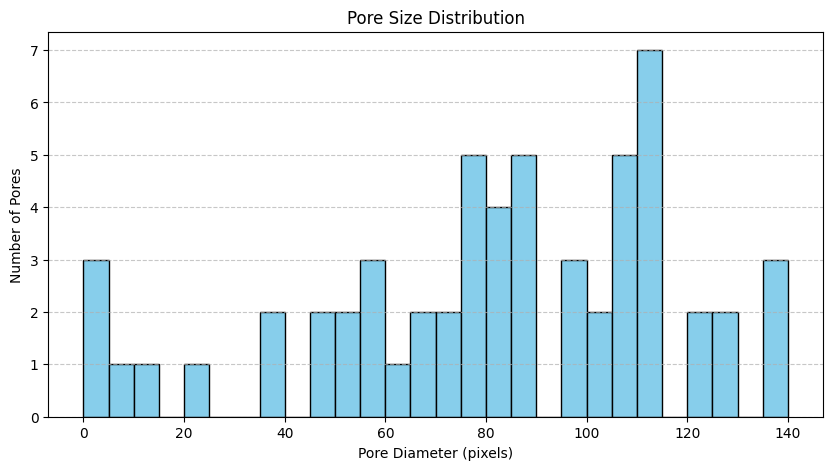

In [44]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load SEM Image in Grayscale
image = cv2.imread('sample2A.jpg', cv2.IMREAD_GRAYSCALE)
if image is None:
    raise ValueError("Image not found. Check the file path.")

# Step 1: Preprocess the Image (Thresholding and Cleaning)
_, binary_image = cv2.threshold(image, 128, 255, cv2.THRESH_BINARY_INV)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
cleaned_image = cv2.morphologyEx(binary_image, cv2.MORPH_OPEN, kernel)

# Step 2: Find Contours of Pores
contours, _ = cv2.findContours(cleaned_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Step 3: Calculate Pore Diameters
pore_diameters = []
for contour in contours:
    area = cv2.contourArea(contour)
    equivalent_diameter = 2 * np.sqrt(area / np.pi)  # Diameter of a circle with the same area
    pore_diameters.append(equivalent_diameter)

# Step 4: Bin the Pore Diameters for the Bar Chart
# Define bin edges (adjust based on your pore size range)
bin_edges = np.arange(0, max(pore_diameters) + 5, 5)  # Bins of 5 units (e.g., pixels)
hist, bin_edges = np.histogram(pore_diameters, bins=bin_edges)

# Step 5: Plot the Bar Chart
plt.figure(figsize=(10, 5))
plt.bar(bin_edges[:-1], hist, width=5, align='edge', color='skyblue', edgecolor='black')
plt.xlabel('Pore Diameter (pixels)')
plt.ylabel('Number of Pores')
plt.title('Pore Size Distribution')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()